In [12]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import combinations, product
from tqdm import tqdm  # progress bar
from math import sqrt

In [13]:
# import data
allTrain = pd.read_csv('D:/notebooks/coursework/dataset/train.csv')
n = len(allTrain)
X_train = allTrain.drop('label', 1).to_numpy()
Y_train = allTrain['label'].to_numpy()
del allTrain
test = pd.read_csv('D:/notebooks/coursework/dataset/test.csv')
X_test = test.to_numpy()
print("data import complete")

C:\Users\ALEX\AppData\Local\Temp\ipykernel_4052\1560496564.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = allTrain.drop('label', 1).to_numpy()


data import complete


In [14]:
class Hamming_Net(object):
    def __init__(self, x):
        self.k = len(x)
        self.m = len(x[0])
        self.w = np.zeros((self.k, self.m))
        for i in range(self.k):
            for j in range(self.m):
                self.w[i][j] = x[i][j] / 2
        self.T = self.m / 2  # параметр активационной функции
        self.e = round(1 / len(x), 1)
        self.E = [[0 for j in range(self.k)] for i in range(self.k)]
        self.Emax = 0.000001  # максимально допустимое значение нормы разности выходных векторов на двух последовательных итерациях
        self.U = 1 / self.Emax
        for i in range(self.k):
            for j in range(self.k):
                if j == i:
                    self.E[i][j] = 1.0
                else:
                    self.E[i][j] = -self.e

    def defineLabel(self, y):
        s = [self.product(self.w, y, self.T)]
        p = self.action(s[0], self.U, self.Emax)
        y = [p]
        i = 0
        p = [0 for j in range(len(s[0]))]
        while self.norm(y[i], p) >= self.Emax:
            s.append([0 for j in range(len(s[0]))])
            for j in range(len(s[0])):
                s[i + 1][j] = y[i][j] - self.e * self.mysum(y[i], j)
            y.append((self.action(s[i + 1], self.U, self.Emax)))
            i += 1
            p = y[i - 1]
        return y[len(y) - 1].index(max(y[len(y) - 1]))

    def processBatch(self, Y):
        '''input should be same size format as patterns. Implements asynchronous update'''
        return np.array([self.defineLabel(y) for y in tqdm(Y)])

    def product(self, w, y, T):  # функция умножения матрицы на вектор
        z = []
        for i in range(len(w)):
            x = 0
            for j in range(len(y)):
                x = x + w[i][j] * y[j]
            z.append((x + T))
        return z

    def action(self, s, T, Emax):  # активационная функция
        t = []
        for i in s:
            if i <= 0:
                t.append(0)
            elif 0 < i <= T:
                t.append(i)
            elif i > T:
                t.append(T)
        return t

    def mysum(self, y, j):  # функция для вычисления суммы значений вектора при  i != j
        p = 0
        sum = 0
        while p < len(y):
            if p != j:
                sum = sum + y[p]
            p += 1
        return sum

    def norm(self, v, p):  # функция вычисляющая разность двух векторов и вычисляющая норму получившегося вектора
        t = []
        for i in range(len(v)):
            t.append(v[i] - p[i])
        sum = 0
        for i in t:
            sum += i * i
        return sqrt(sum)




100%|██████████| 8/8 [00:00<00:00, 3998.86it/s]


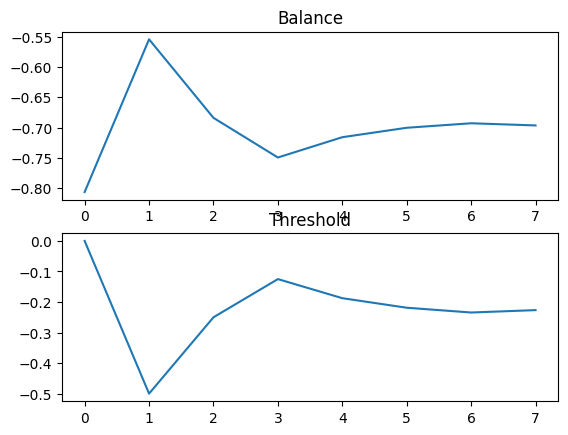

In [15]:
# create patterns
supervised = True
factor = 2.0 / np.max(X_train)
avg_classes = lambda: np.array([factor * np.mean(X_train[Y_train == l, :], axis=0) - 1.0
                                for l in np.unique(Y_train)])
patterns = avg_classes() if supervised else (factor * X_train - 1)

# convert to bitwise
low = -1.0
high = 1.0
iters = 8
metric = np.zeros(iters)
threshold = np.zeros(iters)
for i in tqdm(range(iters)):
    threshold[i] = (low + high) / 2
    metric[i] = np.mean(np.where(patterns < threshold[i], -1, 1))
    if metric[i] > -0.7:  # 0.7 chosen by inspection
        low = threshold[i]
    else:
        high = threshold[i]
bitPatterns = np.where(patterns < threshold[-1], -1, 1)
XB_train = np.where((factor * X_train - 1) < threshold[-1], -1, 1) if supervised else bitPatterns
XB_test = np.where((factor * X_test - 1) < threshold[-1], -1, 1)

plt.subplot(211)
plt.title('Balance')
plt.plot(metric)
plt.subplot(212)
plt.title('Threshold')
plt.plot(threshold)

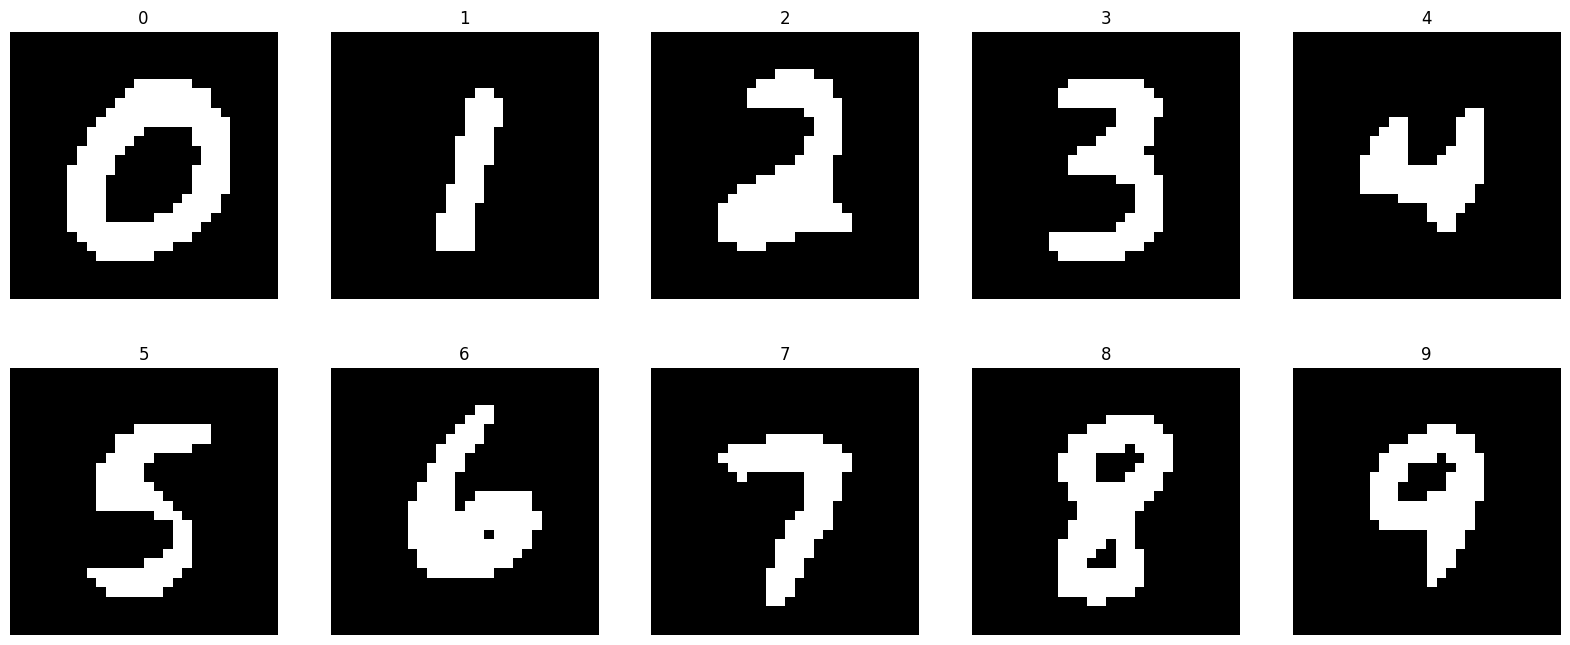

In [16]:
#peek at patterns
plt.figure(figsize=[20, 8])
for i in range(min(len(bitPatterns), 10)):
    plt.subplot(2, 5, i + 1)
    plt.title(i if supervised else Y_train[i])
    plt.axis('off')
    plt.imshow(bitPatterns[i].reshape((28, 28)), cmap='gray')

In [17]:
hamming = Hamming_Net(bitPatterns)
predict = hamming.processBatch(XB_train)




  0%|          | 0/42000 [00:00<?, ?it/s]


  0%|          | 18/42000 [00:00<03:55, 178.22it/s]


  0%|          | 37/42000 [00:00<03:50, 181.84it/s]


  0%|          | 56/42000 [00:00<03:48, 183.86it/s]


  0%|          | 75/42000 [00:00<03:45, 185.53it/s]


  0%|          | 94/42000 [00:00<03:48, 183.20it/s]


  0%|          | 113/42000 [00:00<03:48, 183.63it/s]


  0%|          | 132/42000 [00:00<03:52, 179.91it/s]


  0%|          | 151/42000 [00:00<03:49, 182.45it/s]


  0%|          | 170/42000 [00:00<03:51, 180.90it/s]


  0%|          | 189/42000 [00:01<03:51, 180.91it/s]


  0%|          | 208/42000 [00:01<03:49, 181.99it/s]


  1%|          | 227/42000 [00:01<03:47, 183.81it/s]


  1%|          | 246/42000 [00:01<03:48, 182.40it/s]


  1%|          | 265/42000 [00:01<04:03, 171.54it/s]


  1%|          | 283/42000 [00:01<04:04, 170.56it/s]


  1%|          | 301/42000 [00:01<04:09, 167.10it/s]


  1%|          | 318/42000 [00:01<04:09, 166.98it/s]


  1%|          | 336/42

In [19]:
from sklearn.metrics import classification_report

print(classification_report(Y_train, predict))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4132
           1       0.48      0.99      0.65      4684
           2       0.87      0.58      0.70      4177
           3       0.70      0.70      0.70      4351
           4       0.70      0.77      0.73      4072
           5       0.63      0.52      0.57      3795
           6       0.84      0.69      0.76      4137
           7       0.78      0.80      0.79      4401
           8       0.87      0.53      0.66      4063
           9       0.70      0.63      0.67      4188

    accuracy                           0.71     42000
   macro avg       0.75      0.70      0.71     42000
weighted avg       0.75      0.71      0.71     42000

